# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

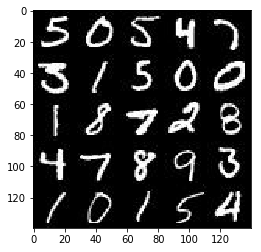

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

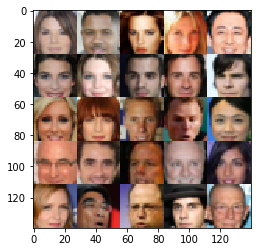

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels),
                                 name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 (or 28x28x1 for mnist)
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        fc = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        fc = tf.reshape(fc, (-1, 4, 4, 512))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = tf.maximum(alpha * fc, fc)
        # 4x4x512 
        
        convT1 = tf.layers.conv2d_transpose(fc, 512, 5, strides=2, padding='valid')
        convT1 = tf.layers.batch_normalization(convT1, training=is_train)
        convT1 = tf.maximum(alpha * convT1, convT1)
        # 11x11x512 
        
        convT2 = tf.layers.conv2d_transpose(convT1, 256, 5, strides=2, padding='same')
        convT2 = tf.layers.batch_normalization(convT2, training=is_train)
        convT2 = tf.maximum(alpha * convT2, convT2)
        # 22x22x256 
        
        convT3 = tf.layers.conv2d_transpose(convT2, 128, 3, strides=1, padding='valid')
        convT3 = tf.layers.batch_normalization(convT3, training=is_train)
        convT3 = tf.maximum(alpha * convT3, convT3)
        # 24x24x128 
        
        # Output layer
        logits = tf.layers.conv2d_transpose(convT3, out_channel_dim, 5, strides=1, padding='valid')
        # 28x28x3 (or 28x28x1) 
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    
    _, img_h, img_w, img_c = data_shape 
    input_real, input_z, learning_rate_ = model_inputs(img_w, img_h, img_c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_c)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 36
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescale input to [-1, 1]
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                              learning_rate_: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_c, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 9.2968
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 2.6517
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 3.6486
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 1.7254
Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 2.0226... Generator Loss: 0.3272
Epoch 1/2... Discriminator Loss: 1.6210... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.6999... Generator Loss: 0.3807


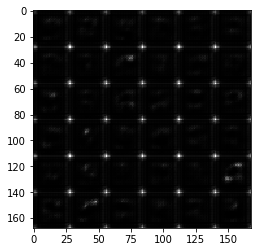

Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 0.3494
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.3957
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.4657
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.6216


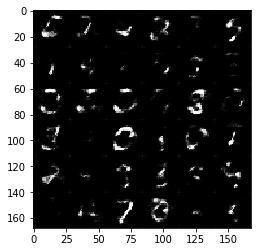

Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.4867
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 2.0871
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 1.8788
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 1.5418
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 1.8376
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 2.0981


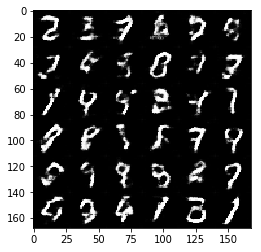

Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.8729
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.7426
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 1.3937
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 1.5217
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.9399
Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 0.3863


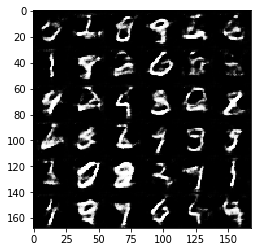

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.5959... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.4862
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 1.4617
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.6044... Generator Loss: 0.3786


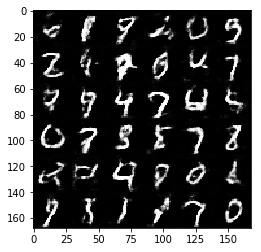

Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.4973
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.6721... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 1.1936


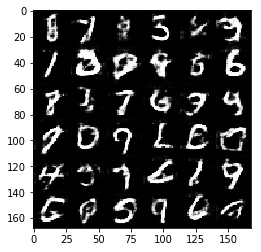

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 1.1638
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.3320
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 0.4538


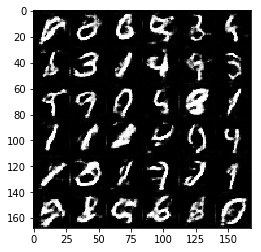

Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.5217
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 0.5296


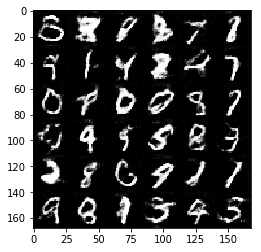

Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.4040
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 1.3452


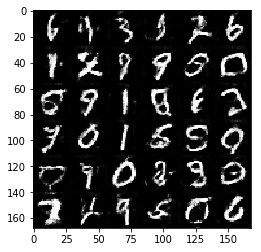

Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.4218
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4876
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 1.2549


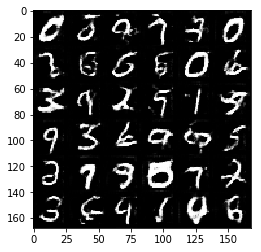

Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 1.5635
Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.4083... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.6946


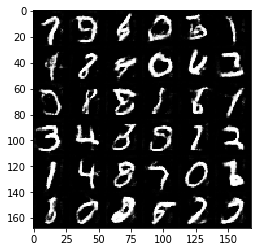

Epoch 2/2... Discriminator Loss: 1.4960... Generator Loss: 0.4177
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.6108... Generator Loss: 0.3994
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.5746


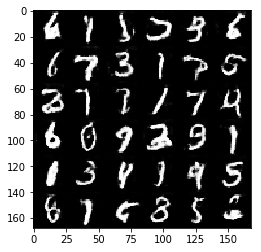

Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.5434... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.7957


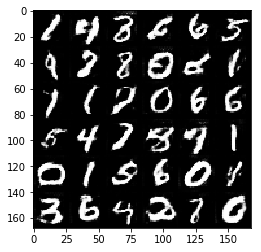

Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 3.0183... Generator Loss: 3.7490
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.4828


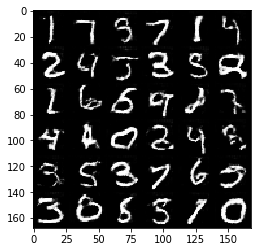

Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.5326... Generator Loss: 1.6985
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.5171
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.3697
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 1.0237


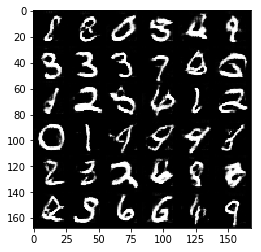

Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.9807
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 1.5810
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.0127


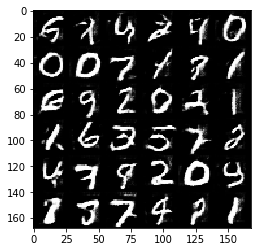

Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.5693
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 1.1542
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 1.2804


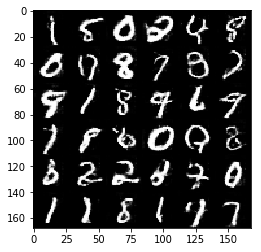

Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.5891
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.6012
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.6018... Generator Loss: 1.6385


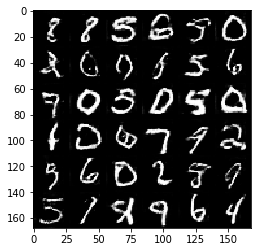

Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 1.0588
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 1.2883
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 1.1572
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 0.8796


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 13.4235
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 3.4838
Epoch 1/1... Discriminator Loss: 2.3721... Generator Loss: 21.9386
Epoch 1/1... Discriminator Loss: 2.1939... Generator Loss: 0.2455
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 2.0133... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2873


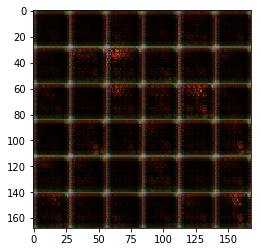

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 2.3585
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 3.5885
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 4.0601
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 2.4944
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.5374


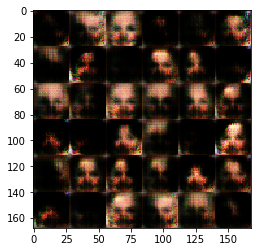

Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 3.0475
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.9197... Generator Loss: 0.2829
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 2.1706
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.7990
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.3441


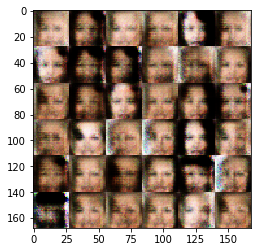

Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.8098... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.7454


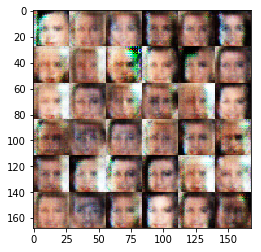

Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.3944
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 2.0080
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6180


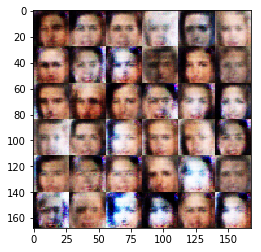

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 1.1834


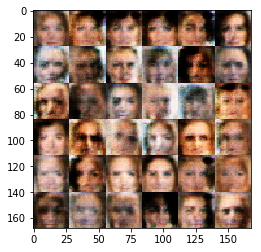

Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6200


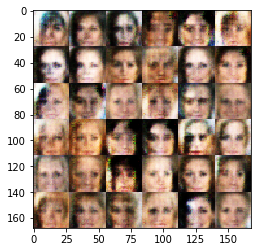

Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.9857... Generator Loss: 0.2745


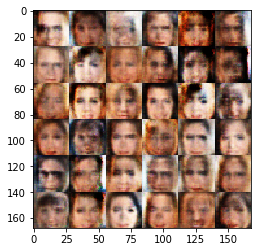

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6465


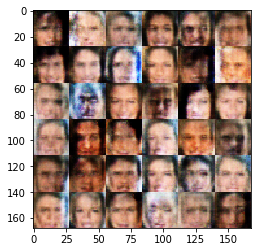

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.9201... Generator Loss: 0.2608
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9821


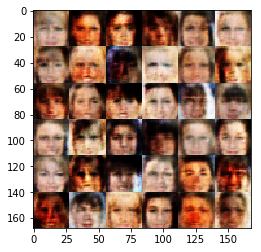

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.4064


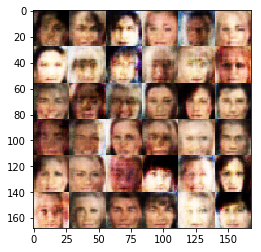

Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.7170... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 1.4085


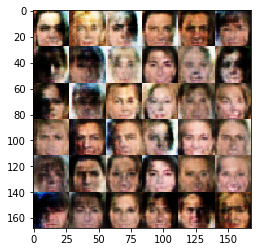

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 1.2784


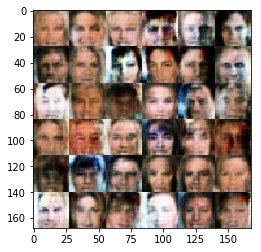

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.4025


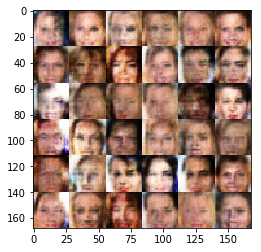

Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.1590


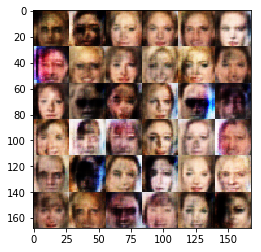

Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8455


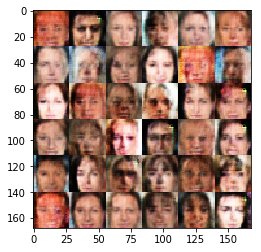

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7614


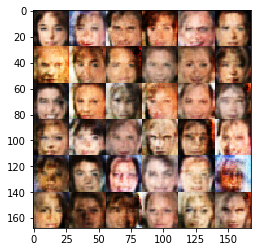

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.4687


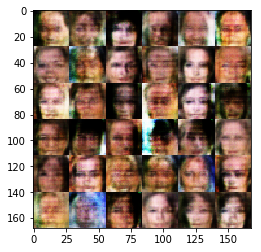

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7338


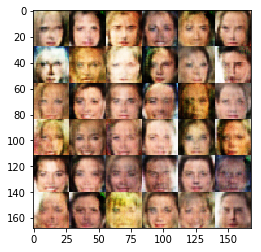

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7708


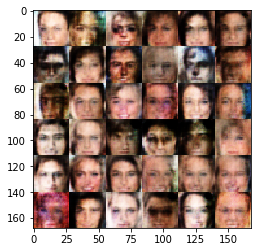

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5039


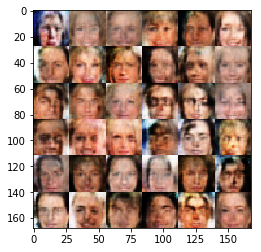

Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9061


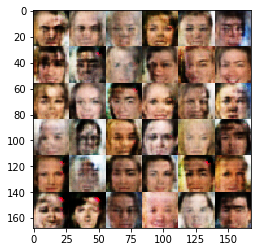

Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5157


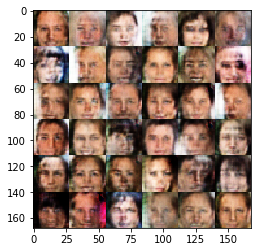

Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.9396... Generator Loss: 0.2477
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9260


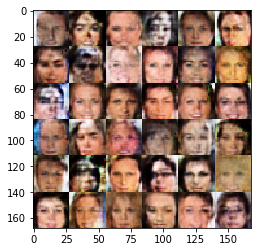

Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.1556


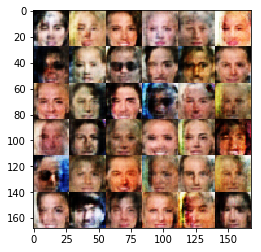

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3863
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9335


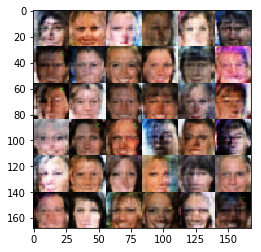

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9857


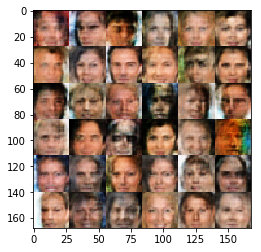

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.3612


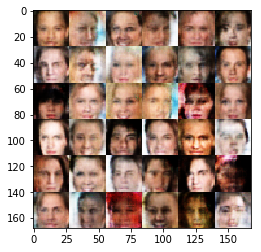

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.5881


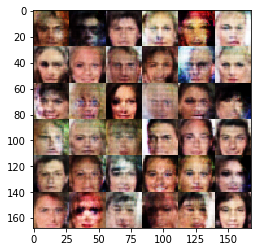

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.3684
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7282


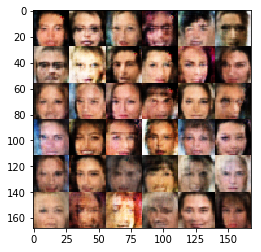

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 1.1538


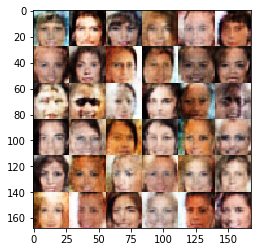

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5305


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.